In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [4]:
gt = pd.read_csv("/content/drive/MyDrive/thesis/gt_cdc/merged_chlamydia.csv")
cdc = pd.read_csv("/content/drive/MyDrive/thesis/gt_cdc/Chlamydia_state_2018_2023.csv")

print(gt.head())
print(cdc.head())

         Date  Index State  FIPS
0  2018-01-01     93    AK     2
1  2018-01-01     87    AL     1
2  2018-01-01     86    AR     5
3  2018-01-01     91    AZ     4
4  2018-01-01     90    CA     6
   Indicator  Year   Geography  FIPS    Cases Rate per 100000  Population
0  Chlamydia  2023     Alabama     1   33,261           651.1   5,108,468
1  Chlamydia  2023      Alaska     2    5,117           697.7     733,406
2  Chlamydia  2023     Arizona     4   41,058           552.5   7,431,344
3  Chlamydia  2023    Arkansas     5   17,781           579.6   3,067,732
4  Chlamydia  2023  California     6  191,357           491.1  38,965,193


## Data Pre-process

In [12]:
# gt data pre-process

gt["Date"] = pd.to_datetime(gt["Date"])
gt["Year"] = gt["Date"].dt.year

gt_annual = (
    gt.groupby(["FIPS", "Year"])["Index"]
    .mean()
    .reset_index()
    .rename(columns={"Index": "GT_Index"})
)

In [13]:
print(gt_annual.head(10))

   FIPS  Year   GT_Index
0     1  2018  89.583333
1     1  2019  90.333333
2     1  2020  75.166667
3     1  2021  79.500000
4     1  2022  81.333333
5     1  2023  86.416667
6     1  2024  81.333333
7     1  2025  80.000000
8     2  2018  70.416667
9     2  2019  73.583333


In [14]:
# cdc data pre-process

cdc = cdc.rename(columns={
    "Geography": "State",
    "Rate per 100000": "CDC_Rate"
})
cdc = cdc[["FIPS", "State", "Year", "CDC_Rate"]]
cdc["CDC_Rate"] = pd.to_numeric(cdc["CDC_Rate"], errors="coerce")
cdc["FIPS"] = pd.to_numeric(cdc["FIPS"], errors="coerce").astype("Int64")

In [15]:
print(cdc.head(10))

   FIPS                 State  Year  CDC_Rate
0     1               Alabama  2023     651.1
1     2                Alaska  2023     697.7
2     4               Arizona  2023     552.5
3     5              Arkansas  2023     579.6
4     6            California  2023     491.1
5     8              Colorado  2023     435.1
6     9           Connecticut  2023     364.8
7    10              Delaware  2023     552.7
8    11  District of Columbia  2023    1228.0
9    12               Florida  2023     498.9


In [16]:
# merge
merged = pd.merge(cdc, gt_annual, on=["FIPS","Year"], how="inner")

In [17]:
print(merged.head())

   FIPS       State  Year  CDC_Rate   GT_Index
0     1     Alabama  2023     651.1  86.416667
1     2      Alaska  2023     697.7  66.416667
2     4     Arizona  2023     552.5  78.416667
3     5    Arkansas  2023     579.6  83.916667
4     6  California  2023     491.1  81.250000


## Analysis

In [18]:
pearson_corr = merged[["CDC_Rate","GT_Index"]].corr().iloc[0,1]
print(f"Overall Pearson correlation: {pearson_corr:.3f}")

Overall Pearson correlation: 0.333


In [42]:
state_corrs = (
    merged.groupby("State")
    .apply(lambda g: g["CDC_Rate"].corr(g["GT_Index"]), include_groups=False)
    .reset_index(name="corr")
)


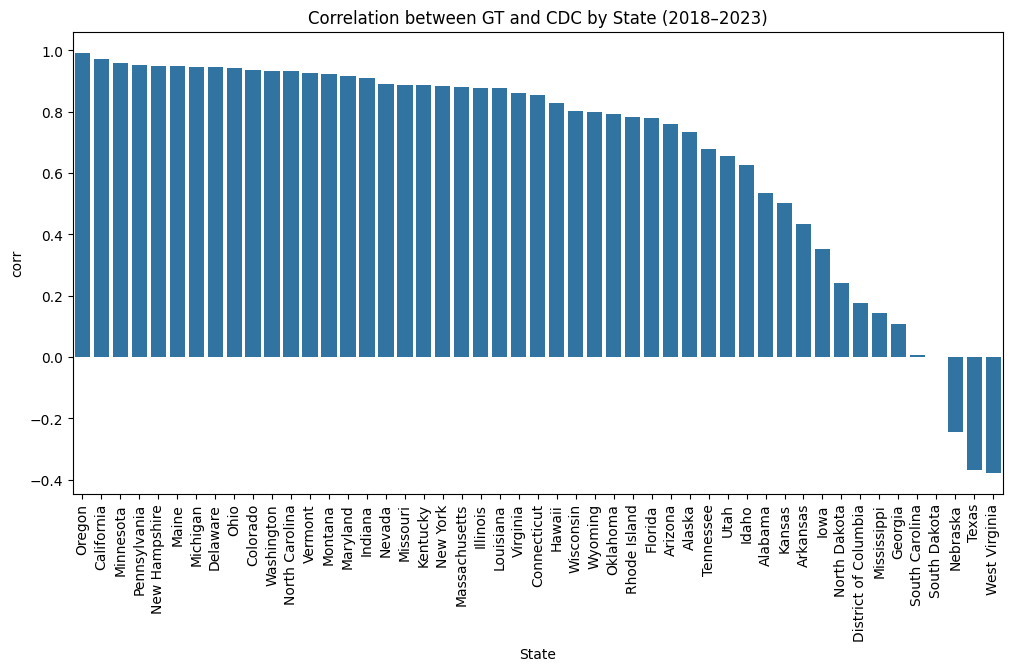

In [43]:
plt.figure(figsize=(12,6))
sns.barplot(data=state_corrs.sort_values("corr", ascending=False), x="State", y="corr")
plt.xticks(rotation=90)
plt.title("Correlation between GT and CDC by State (2018–2023)")
plt.show()

### Regression

In [35]:
# Pooled OLS
m1 = smf.ols("CDC_Rate ~ GT_Index", data=merged).fit(cov_type="HC1")

# State FE
m2 = smf.ols("CDC_Rate ~ GT_Index + C(State)", data=merged).fit(cov_type="HC1")

# Year FE
m3 = smf.ols("CDC_Rate ~ GT_Index + C(Year)", data=merged).fit(cov_type="HC1")

# Two-way FE
m4 = smf.ols("CDC_Rate ~ GT_Index + C(State) + C(Year)", data=merged).fit(cov_type="HC1")

In [38]:
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     37.05
Date:                Thu, 02 Oct 2025   Prob (F-statistic):           3.62e-09
Time:                        07:48:24   Log-Likelihood:                -1888.0
No. Observations:                 293   AIC:                             3780.
Df Residuals:                     291   BIC:                             3787.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.2154     73.573      0.982      0.3

In [39]:
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     235.1
Date:                Thu, 02 Oct 2025   Prob (F-statistic):          8.25e-179
Time:                        07:48:37   Log-Likelihood:                -1443.3
No. Observations:                 293   AIC:                             2987.
Df Residuals:                     243   BIC:                             3171.
Df Model:                          49                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [40]:
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     8.233
Date:                Thu, 02 Oct 2025   Prob (F-statistic):           3.13e-08
Time:                        07:48:45   Log-Likelihood:                -1886.9
No. Observations:                 293   AIC:                             3788.
Df Residuals:                     286   BIC:                             3814.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -19.0473    155.221     

In [41]:
print(m4.summary())

                            OLS Regression Results                            
Dep. Variable:               CDC_Rate   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     185.4
Date:                Thu, 02 Oct 2025   Prob (F-statistic):          6.84e-167
Time:                        07:48:53   Log-Likelihood:                -1424.1
No. Observations:                 293   AIC:                             2958.
Df Residuals:                     238   BIC:                             3161.
Df Model:                          54                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### Plots


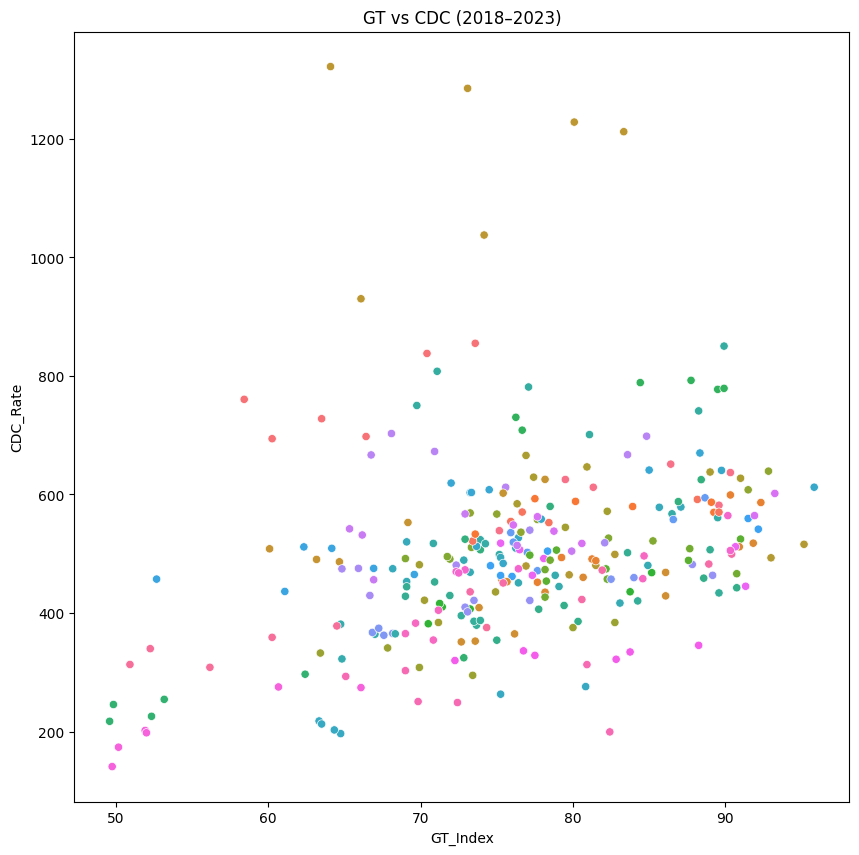

In [34]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=merged, x="GT_Index", y="CDC_Rate", hue="State", legend = False)
plt.title("GT vs CDC (2018–2023)")
plt.show()